In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
import numpy as np
import math
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

In [3]:
data = pd.read_csv('pharma/salesmonthly.csv',parse_dates=['datum'],index_col='datum')
data['Year'] = pd.DatetimeIndex(data.index).year
data['Month'] = pd.DatetimeIndex(data.index).month

In [3]:
data.head()

,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month
datum,,,,,,,,,,
2014-01-31,127.69,99.090,152.100,878.030,354.0,50.0,112.0,48.2,2014,1
2014-02-28,133.32,126.050,177.000,1001.900,347.0,31.0,122.0,36.2,2014,2
2014-03-31,137.44,92.950,147.655,779.275,232.0,20.0,112.0,85.4,2014,3
2014-04-30,113.10,89.475,130.900,698.500,209.0,18.0,97.0,73.7,2014,4
2014-05-31,101.79,119.933,132.100,628.780,270.0,23.0,107.0,123.7,2014,5


In [4]:
n_estimators = [int(x) for x in np.linspace(start = 5,stop = 15,num=11)]
max_depth = [int(x) for x in np.linspace(3,10,num=7)]

In [5]:
dates = data.index
dates[-6:]

DatetimeIndex(['2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31'],
              dtype='datetime64[ns]', name='datum', freq=None)

In [6]:
dict = {}

## M01AB 

In [13]:
cols = ["M01AB","Year","Month"]
df = data.loc[:,cols]
arr_mean = df['M01AB'].rolling(3).mean()
df['MA'] = arr_mean
df['lag1'] = df['M01AB'].shift(1)
df['lag2'] = df['M01AB'].shift(2)
df.fillna(0,inplace=True)
df = df.reset_index()
del df['datum']

In [14]:
df

,M01AB,Year,Month,MA,lag1,lag2
0,127.69,2014,1,0.000000,0.00,0.00
1,133.32,2014,2,0.000000,127.69,0.00
2,137.44,2014,3,132.816667,133.32,127.69
3,113.10,2014,4,127.953333,137.44,133.32
4,101.79,2014,5,117.443333,113.10,137.44
...,...,...,...,...,...,...
65,151.54,2019,6,160.323333,168.04,161.39
66,181.00,2019,7,166.860000,151.54,168.04
67,181.91,2019,8,171.483333,181.00,151.54
68,161.07,2019,9,174.660000,181.91,181.00


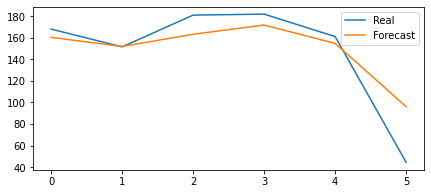

In [15]:
features = df.drop(['M01AB'],axis=1)
target = df['M01AB']
x_train = features[:-6]
y_train = target[:-6]
x_test = features[-6:]
y_test = target[-6:]
y_test = np.asarray(y_test)
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
predictions_lr = lr_model.predict(x_test)
fig = plt.figure(figsize=(7,3))
plt.plot(y_test,label='Real')
plt.plot(predictions_lr,label='Forecast')
plt.legend()

In [41]:
rmse_lr = math.sqrt(mean_squared_error(y_test,predictions_lr))
dict['LR'] = rmse_lr
print(rmse_lr)

23.026081747029963


In [17]:
dt_model = DecisionTreeRegressor(criterion='mse')
parameters = {
    'max_depth' : max_depth
}
model = GridSearchCV(dt_model, param_grid=parameters, scoring='neg_mean_absolute_error', cv=10)
model.fit(x_train,y_train)
model.best_params_

{'max_depth': 3}

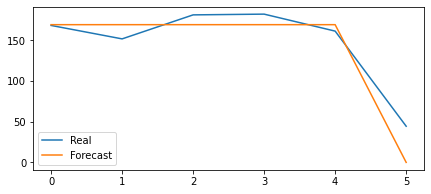

In [18]:
dt_model = DecisionTreeRegressor(criterion='mse',max_depth=3)
dt_model.fit(x_train,y_train)
predictions_dt = dt_model.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(7,3))
plt.plot(y_test,label='Real')
plt.plot(predictions_dt,label='Forecast')
plt.legend()

In [42]:
rmse_dt = math.sqrt(mean_squared_error(y_test,predictions_dt))
dict['DT'] = rmse_dt
print(rmse_dt)

21.007790942222094


In [21]:
rf = RandomForestRegressor(random_state = 1)
parameters = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth
    
}

model = GridSearchCV(rf, param_grid=parameters, scoring='neg_mean_absolute_error', cv=3)
model.fit(x_train,y_train)
model.best_params_

{'max_depth': 3, 'n_estimators': 9}

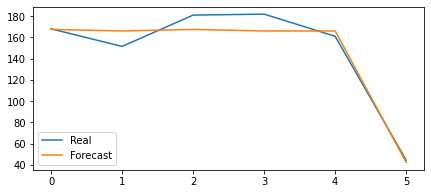

In [20]:
rf = RandomForestRegressor(random_state = 1,max_depth = 3,n_estimators = 9)
rf.fit(x_train, y_train)
predictions_rf = rf.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(7,3))
plt.plot(y_test,label='Real')
plt.plot(predictions_rf,label='Forecast')
plt.legend()

In [43]:
rmse_rf = math.sqrt(mean_squared_error(y_test,predictions_rf))
dict['RF'] = rmse_rf
print(rmse_rf)

10.586704654606605


In [25]:
xg = xgb.XGBRegressor(objective = 'reg:squarederror')
parameters = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth,
    'colsample_bytree': [0.5, 0.7],
    'learning_rate' : [0.05, 0.10, 0.15, 0.20]
    
}
model = GridSearchCV(xg, param_grid=parameters,cv=3)
model.fit(x_train,y_train)
model.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.2,
 'max_depth': 7,
 'n_estimators': 15}

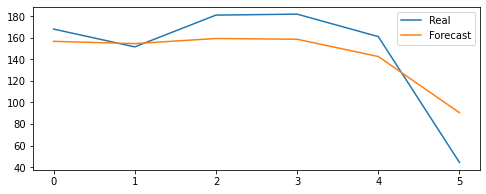

In [22]:
xg = xgb.XGBRegressor(objective = 'reg:squarederror',n_estimators = 15,max_depth = 7,colsample_bytree= 0.7,learning_rate=0.2)
xg.fit(x_train,y_train)
predictions_xg = xg.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions_xg,label='Forecast')
plt.legend()

In [44]:
rmse_xg = math.sqrt(mean_squared_error(y_test,predictions_xg))
dict['XG'] = rmse_xg
print(rmse_xg)

24.557977221761426


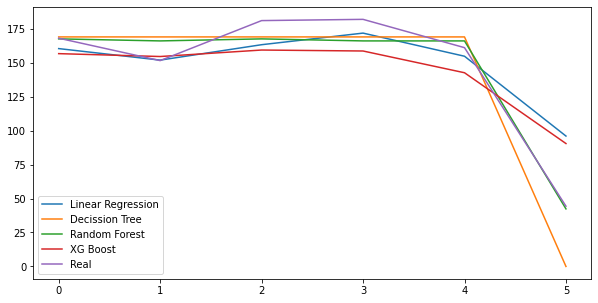

In [39]:
fig = plt.figure(figsize=(10,5))
plt.plot(predictions_lr,label='Linear Regression')
plt.plot(predictions_dt,label='Decission Tree')
plt.plot(predictions_rf,label='Random Forest')
plt.plot(predictions_xg,label='XG Boost')
plt.plot(y_test,label='Real')
plt.legend()

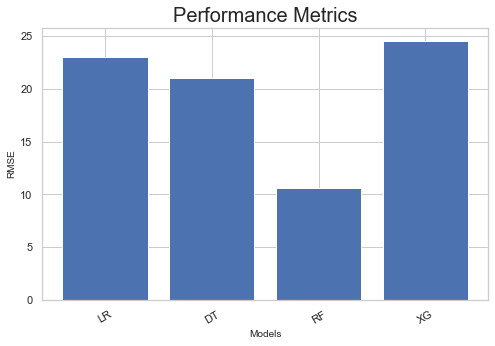

In [52]:
plt.figure(figsize=(8,5))
sns.set_theme(style='whitegrid')
plt.bar(dict.keys(),dict.values())
plt.title('Performance Metrics',size=20)
plt.xlabel('Models' , size=10)
plt.ylabel('RMSE' , size=10)
plt.xticks(rotation=30)
plt.show()

## M01AE

In [7]:
cols = ["M01AE","Year","Month"]
df = data.loc[:,cols]
arr_mean = df['M01AE'].rolling(3).mean()
df['MA'] = arr_mean
df['lag1'] = df['M01AE'].shift(1)
df['lag2'] = df['M01AE'].shift(2)
df.fillna(0,inplace=True)
df = df.reset_index()
del df['datum']
features = df.drop(['M01AE'],axis=1)
target = df['M01AE']
x_train = features[:-6]
y_train = target[:-6]
x_test = features[-6:]
y_test = target[-6:]
y_test = np.asarray(y_test)

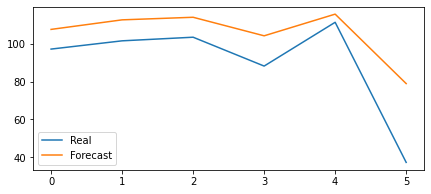

In [9]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
predictions_lr = lr_model.predict(x_test)
fig = plt.figure(figsize=(7,3))
plt.plot(y_test,label='Real')
plt.plot(predictions_lr,label='Forecast')
plt.legend()

In [30]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
dict['LR'] = 
print(rmse)

19.82031129699866


In [31]:
dt_model = DecisionTreeRegressor(criterion='mse')
parameters = {
    'max_depth' : max_depth
}
model = GridSearchCV(dt_model, param_grid=parameters, scoring='neg_mean_absolute_error', cv=3)
model.fit(x_train,y_train)
model.best_params_

{'max_depth': 8}

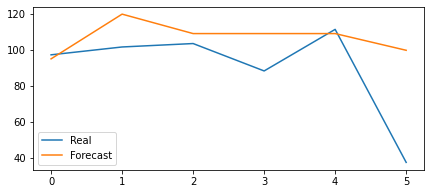

In [32]:
dt_model = DecisionTreeRegressor(criterion='mse',max_depth=8)
dt_model.fit(x_train,y_train)
predictions = dt_model.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(7,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [33]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

28.02950713979828


In [34]:
rf = RandomForestRegressor(random_state = 1)
parameters = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth
    
}

model = GridSearchCV(rf, param_grid=parameters, scoring='neg_mean_absolute_error', cv=3)
model.fit(x_train,y_train)
model.best_params_

{'max_depth': 8, 'n_estimators': 15}

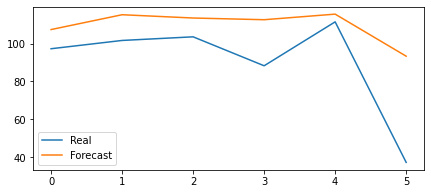

In [35]:
rf = RandomForestRegressor(random_state = 1,max_depth = 8,n_estimators = 15)
rf.fit(x_train, y_train)
predictions = rf.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(7,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [36]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

26.236587832473795


In [37]:
xg = xgb.XGBRegressor(objective = 'reg:squarederror')
parameters = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth,
    'colsample_bytree': [0.5, 0.7],
    'learning_rate' : [0.05, 0.10, 0.15, 0.20]
    
}
model = GridSearchCV(xg, param_grid=parameters,cv=3)
model.fit(x_train,y_train)
model.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.2,
 'max_depth': 3,
 'n_estimators': 15}

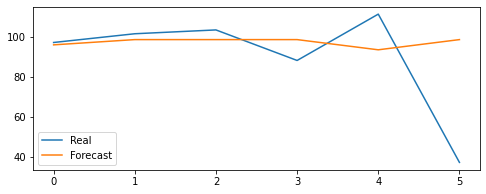

In [38]:
xg = xgb.XGBRegressor(objective = 'reg:squarederror',n_estimators = 15,max_depth = 3,colsample_bytree= 0.7,learning_rate=0.2)
xg.fit(x_train,y_train)
predictions = xg.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [39]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

26.55290417465079


## N02BA

In [40]:
cols = ["N02BA","Year","Month"]
df = data.loc[:,cols]
arr_mean = df['N02BA'].rolling(3).mean()
df['MA'] = arr_mean
df['lag1'] = df['N02BA'].shift(1)
df['lag2'] = df['N02BA'].shift(2)
df.fillna(0,inplace=True)
df = df.reset_index()
del df['datum']
features = df.drop(['N02BA'],axis=1)
target = df['N02BA']
x_train = features[:-6]
y_train = target[:-6]
x_test = features[-6:]
y_test = target[-6:]
y_test = np.asarray(y_test)

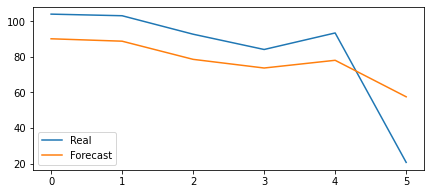

In [41]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
predictions = lr_model.predict(x_test)
fig = plt.figure(figsize=(7,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [42]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

19.607973801204807


In [43]:
dt_model = DecisionTreeRegressor(criterion='mse')
parameters = {
    'max_depth' : max_depth
}
model = GridSearchCV(dt_model, param_grid=parameters, scoring='neg_mean_absolute_error', cv=3)
model.fit(x_train,y_train)
model.best_params_

{'max_depth': 7}

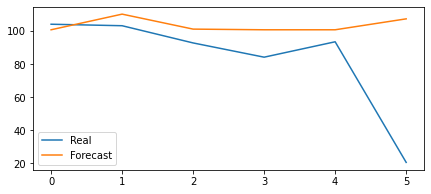

In [44]:
dt_model = DecisionTreeRegressor(criterion='mse',max_depth=7)
dt_model.fit(x_train,y_train)
predictions = dt_model.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(7,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [45]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

36.45385210555028


In [46]:
rf = RandomForestRegressor(random_state = 1)
parameters = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth
    
}

model = GridSearchCV(rf, param_grid=parameters, scoring='neg_mean_absolute_error', cv=3)
model.fit(x_train,y_train)
model.best_params_

{'max_depth': 4, 'n_estimators': 15}

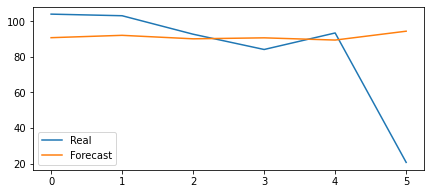

In [47]:
rf = RandomForestRegressor(random_state = 1,max_depth = 4,n_estimators = 15)
rf.fit(x_train, y_train)
predictions = rf.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(7,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [48]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

31.134602494348137


In [49]:
xg = xgb.XGBRegressor(objective = 'reg:squarederror')
parameters = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth,
    'colsample_bytree': [0.5, 0.7],
    'learning_rate' : [0.05, 0.10, 0.15, 0.20]
    
}
model = GridSearchCV(xg, param_grid=parameters,cv=3)
model.fit(x_train,y_train)
model.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.2,
 'max_depth': 6,
 'n_estimators': 15}

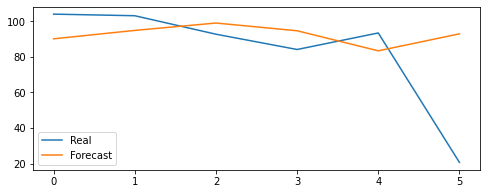

In [50]:
xg = xgb.XGBRegressor(objective = 'reg:squarederror',n_estimators = 15,max_depth = 6,colsample_bytree= 0.5,learning_rate=0.2)
xg.fit(x_train,y_train)
predictions = xg.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [51]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

30.950868860061522


## N02BE

In [53]:
cols = ["N02BE","Year","Month"]
df = data.loc[:,cols]
arr_mean = df['N02BE'].rolling(3).mean()
df['MA'] = arr_mean
df['lag1'] = df['N02BE'].shift(1)
df['lag2'] = df['N02BE'].shift(2)
df.fillna(0,inplace=True)
df = df.reset_index()
del df['datum']
features = df.drop(['N02BE'],axis=1)
target = df['N02BE']
x_train = features[:-6]
y_train = target[:-6]
x_test = features[-6:]
y_test = target[-6:]
y_test = np.asarray(y_test)

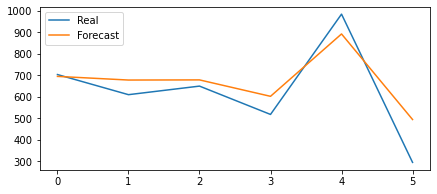

In [54]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
predictions = lr_model.predict(x_test)
fig = plt.figure(figsize=(7,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [55]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

100.70212023373624


In [56]:
dt_model = DecisionTreeRegressor(criterion='mse')
parameters = {
    'max_depth' : max_depth
}
model = GridSearchCV(dt_model, param_grid=parameters, scoring='neg_mean_absolute_error', cv=3)
model.fit(x_train,y_train)
model.best_params_

{'max_depth': 6}

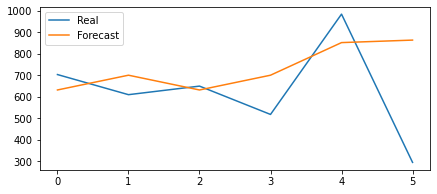

In [57]:
dt_model = DecisionTreeRegressor(criterion='mse',max_depth=6)
dt_model.fit(x_train,y_train)
predictions = dt_model.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(7,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [58]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

254.21838405984087


In [59]:
rf = RandomForestRegressor(random_state = 1)
parameters = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth
    
}

model = GridSearchCV(rf, param_grid=parameters, scoring='neg_mean_absolute_error', cv=3)
model.fit(x_train,y_train)
model.best_params_

{'max_depth': 6, 'n_estimators': 7}

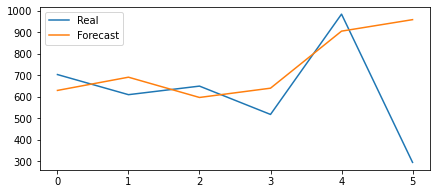

In [60]:
rf = RandomForestRegressor(random_state = 1,max_depth = 6,n_estimators = 7)
rf.fit(x_train, y_train)
predictions = rf.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(7,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [61]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

281.781489172857


In [62]:
xg = xgb.XGBRegressor(objective = 'reg:squarederror')
parameters = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth,
    'colsample_bytree': [0.5, 0.7],
    'learning_rate' : [0.05, 0.10, 0.15, 0.20]
    
}
model = GridSearchCV(xg, param_grid=parameters,cv=3)
model.fit(x_train,y_train)
model.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.2,
 'max_depth': 3,
 'n_estimators': 15}

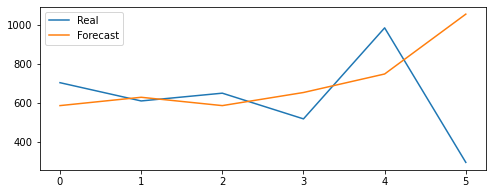

In [63]:
xg = xgb.XGBRegressor(objective = 'reg:squarederror',n_estimators = 15,max_depth = 3,colsample_bytree= 0.7,learning_rate=0.2)
xg.fit(x_train,y_train)
predictions = xg.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [64]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

334.0297145451211


## N05B

In [65]:
cols = ["N05B","Year","Month"]
df = data.loc[:,cols]
arr_mean = df['N05B'].rolling(3).mean()
df['MA'] = arr_mean
df['lag1'] = df['N05B'].shift(1)
df['lag2'] = df['N05B'].shift(2)
df.fillna(0,inplace=True)
df = df.reset_index()
del df['datum']
features = df.drop(['N05B'],axis=1)
target = df['N05B']
x_train = features[:-6]
y_train = target[:-6]
x_test = features[-6:]
y_test = target[-6:]
y_test = np.asarray(y_test)

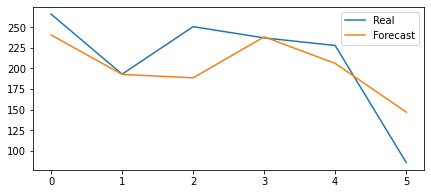

In [66]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
predictions = lr_model.predict(x_test)
fig = plt.figure(figsize=(7,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [67]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

38.04904672566507


In [68]:
dt_model = DecisionTreeRegressor(criterion='mse')
parameters = {
    'max_depth' : max_depth
}
model = GridSearchCV(dt_model, param_grid=parameters, scoring='neg_mean_absolute_error', cv=3)
model.fit(x_train,y_train)
model.best_params_

{'max_depth': 10}

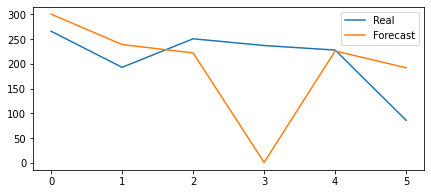

In [69]:
dt_model = DecisionTreeRegressor(criterion='mse',max_depth=10)
dt_model.fit(x_train,y_train)
predictions = dt_model.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(7,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [70]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

108.83194996568486


In [71]:
rf = RandomForestRegressor(random_state = 1)
parameters = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth
    
}

model = GridSearchCV(rf, param_grid=parameters, scoring='neg_mean_absolute_error', cv=3)
model.fit(x_train,y_train)
model.best_params_

{'max_depth': 7, 'n_estimators': 13}

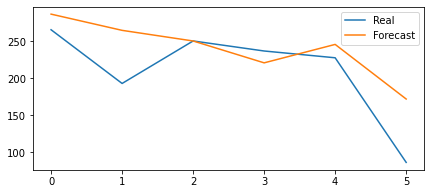

In [72]:
rf = RandomForestRegressor(random_state = 1,max_depth = 7,n_estimators = 13)
rf.fit(x_train, y_train)
predictions = rf.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(7,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [73]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

47.60263242377897


In [74]:
xg = xgb.XGBRegressor(objective = 'reg:squarederror')
parameters = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth,
    'colsample_bytree': [0.5, 0.7],
    'learning_rate' : [0.05, 0.10, 0.15, 0.20]
    
}
model = GridSearchCV(xg, param_grid=parameters,cv=3)
model.fit(x_train,y_train)
model.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.15,
 'max_depth': 4,
 'n_estimators': 15}

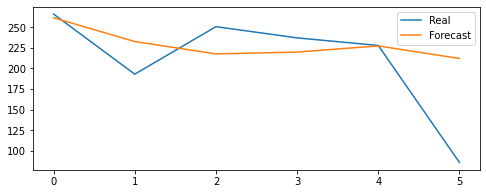

In [75]:
xg = xgb.XGBRegressor(objective = 'reg:squarederror',n_estimators = 15,max_depth = 4,colsample_bytree= 0.5,learning_rate=0.15)
xg.fit(x_train,y_train)
predictions = xg.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [76]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

56.060147531728994


## N05C

In [77]:
cols = ["N05C","Year","Month"]
df = data.loc[:,cols]
arr_mean = df['N05C'].rolling(3).mean()
df['MA'] = arr_mean
df['lag1'] = df['N05C'].shift(1)
df['lag2'] = df['N05C'].shift(2)
df.fillna(0,inplace=True)
df = df.reset_index()
del df['datum']
features = df.drop(['N05C'],axis=1)
target = df['N05C']
x_train = features[:-6]
y_train = target[:-6]
x_test = features[-6:]
y_test = target[-6:]
y_test = np.asarray(y_test)

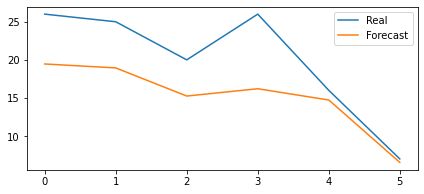

In [78]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
predictions = lr_model.predict(x_test)
fig = plt.figure(figsize=(7,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [79]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

5.770027609413602


In [80]:
dt_model = DecisionTreeRegressor(criterion='mse')
parameters = {
    'max_depth' : max_depth
}
model = GridSearchCV(dt_model, param_grid=parameters, scoring='neg_mean_absolute_error', cv=3)
model.fit(x_train,y_train)
model.best_params_

{'max_depth': 5}

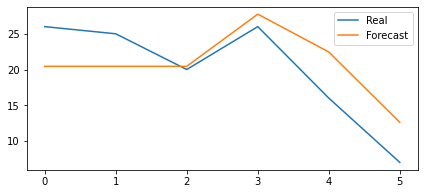

In [81]:
dt_model = DecisionTreeRegressor(criterion='mse',max_depth=5)
dt_model.fit(x_train,y_train)
predictions = dt_model.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(7,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [82]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

4.616969999173488


In [83]:
rf = RandomForestRegressor(random_state = 1)
parameters = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth
    
}

model = GridSearchCV(rf, param_grid=parameters, scoring='neg_mean_absolute_error', cv=3)
model.fit(x_train,y_train)
model.best_params_

{'max_depth': 5, 'n_estimators': 15}

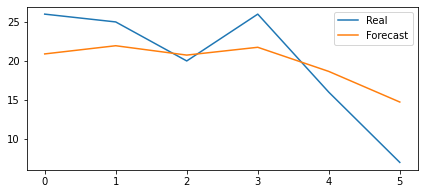

In [84]:
rf = RandomForestRegressor(random_state = 1,max_depth = 5,n_estimators = 15)
rf.fit(x_train, y_train)
predictions = rf.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(7,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [85]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

4.487365476147137


In [86]:
xg = xgb.XGBRegressor(objective = 'reg:squarederror')
parameters = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth,
    'colsample_bytree': [0.5, 0.7],
    'learning_rate' : [0.05, 0.10, 0.15, 0.20]
    
}
model = GridSearchCV(xg, param_grid=parameters,cv=3)
model.fit(x_train,y_train)
model.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.2,
 'max_depth': 6,
 'n_estimators': 15}

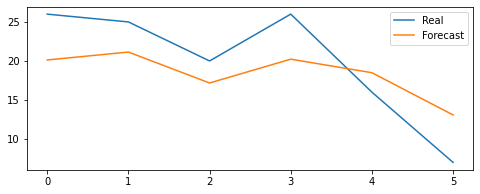

In [87]:
xg = xgb.XGBRegressor(objective = 'reg:squarederror',n_estimators = 15,max_depth = 6,colsample_bytree= 0.7,learning_rate=0.2)
xg.fit(x_train,y_train)
predictions = xg.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [88]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

4.723711827634389


## R03 

In [89]:
cols = ["R03","Year","Month"]
df = data.loc[:,cols]
arr_mean = df['R03'].rolling(3).mean()
df['MA'] = arr_mean
df['lag1'] = df['R03'].shift(1)
df['lag2'] = df['R03'].shift(2)
df.fillna(0,inplace=True)
df = df.reset_index()
del df['datum']
features = df.drop(['R03'],axis=1)
target = df['R03']
x_train = features[:-6]
y_train = target[:-6]
x_test = features[-6:]
y_test = target[-6:]
y_test = np.asarray(y_test)

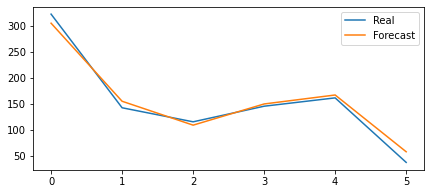

In [90]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
predictions = lr_model.predict(x_test)
fig = plt.figure(figsize=(7,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [91]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

12.706142214138024


In [92]:
dt_model = DecisionTreeRegressor(criterion='mse')
parameters = {
    'max_depth' : max_depth
}
model = GridSearchCV(dt_model, param_grid=parameters, scoring='neg_mean_absolute_error', cv=3)
model.fit(x_train,y_train)
model.best_params_

{'max_depth': 3}

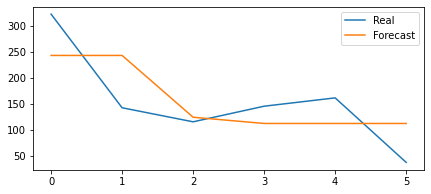

In [93]:
dt_model = DecisionTreeRegressor(criterion='mse',max_depth=3)
dt_model.fit(x_train,y_train)
predictions = dt_model.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(7,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [94]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

65.34519014999991


In [95]:
rf = RandomForestRegressor(random_state = 1)
parameters = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth
    
}

model = GridSearchCV(rf, param_grid=parameters, scoring='neg_mean_absolute_error', cv=3)
model.fit(x_train,y_train)
model.best_params_

{'max_depth': 3, 'n_estimators': 6}

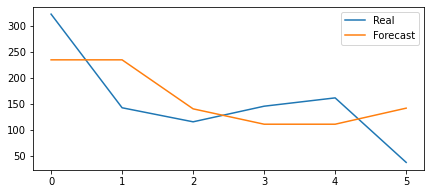

In [96]:
rf = RandomForestRegressor(random_state = 1,max_depth = 3,n_estimators = 6)
rf.fit(x_train, y_train)
predictions = rf.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(7,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [97]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

72.40781669372608


In [98]:
xg = xgb.XGBRegressor(objective = 'reg:squarederror')
parameters = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth,
    'colsample_bytree': [0.5, 0.7],
    'learning_rate' : [0.05, 0.10, 0.15, 0.20]
    
}
model = GridSearchCV(xg, param_grid=parameters,cv=3)
model.fit(x_train,y_train)
model.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.2,
 'max_depth': 3,
 'n_estimators': 15}

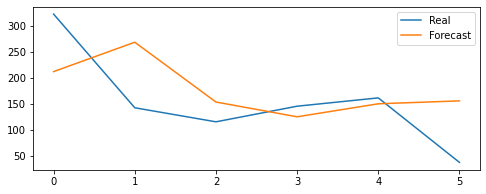

In [99]:
xg = xgb.XGBRegressor(objective = 'reg:squarederror',n_estimators = 15,max_depth = 3,colsample_bytree= 0.7,learning_rate=0.2)
xg.fit(x_train,y_train)
predictions = xg.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [100]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

85.68488582888169


## R06

In [101]:
cols = ["R06","Year","Month"]
df = data.loc[:,cols]
arr_mean = df['R06'].rolling(3).mean()
df['MA'] = arr_mean
df['lag1'] = df['R06'].shift(1)
df['lag2'] = df['R06'].shift(2)
df.fillna(0,inplace=True)
df = df.reset_index()
del df['datum']
features = df.drop(['R06'],axis=1)
target = df['R06']
x_train = features[:-6]
y_train = target[:-6]
x_test = features[-6:]
y_test = target[-6:]
y_test = np.asarray(y_test)

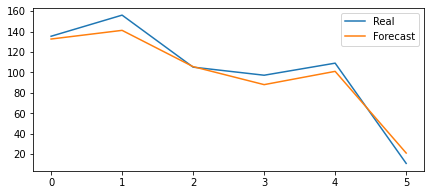

In [102]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
predictions = lr_model.predict(x_test)
fig = plt.figure(figsize=(7,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [103]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

8.946217071900017


In [104]:
dt_model = DecisionTreeRegressor(criterion='mse')
parameters = {
    'max_depth' : max_depth
}
model = GridSearchCV(dt_model, param_grid=parameters, scoring='neg_mean_absolute_error', cv=3)
model.fit(x_train,y_train)
model.best_params_

{'max_depth': 3}

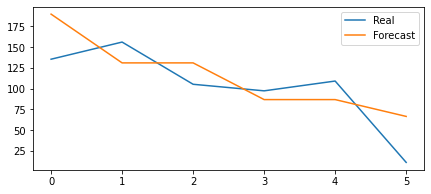

In [105]:
dt_model = DecisionTreeRegressor(criterion='mse',max_depth=3)
dt_model.fit(x_train,y_train)
predictions = dt_model.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(7,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [106]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

36.32093340062439


In [107]:
rf = RandomForestRegressor(random_state = 1)
parameters = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth
    
}

model = GridSearchCV(rf, param_grid=parameters, scoring='neg_mean_absolute_error', cv=3)
model.fit(x_train,y_train)
model.best_params_

{'max_depth': 7, 'n_estimators': 9}

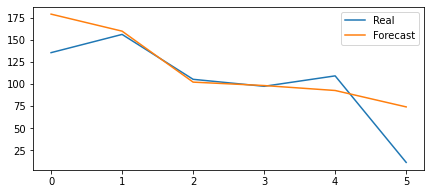

In [108]:
rf = RandomForestRegressor(random_state = 1,max_depth = 7,n_estimators = 9)
rf.fit(x_train, y_train)
predictions = rf.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(7,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [109]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

32.01341567096224


In [110]:
xg = xgb.XGBRegressor(objective = 'reg:squarederror')
parameters = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth,
    'colsample_bytree': [0.5, 0.7],
    'learning_rate' : [0.05, 0.10, 0.15, 0.20]
    
}
model = GridSearchCV(xg, param_grid=parameters,cv=3)
model.fit(x_train,y_train)
model.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.2,
 'max_depth': 3,
 'n_estimators': 15}

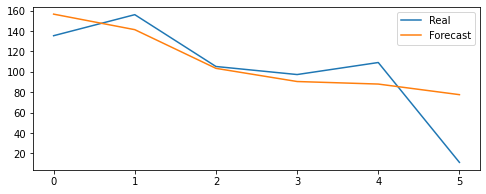

In [111]:
xg = xgb.XGBRegressor(objective = 'reg:squarederror',n_estimators = 15,max_depth = 3,colsample_bytree= 0.7,learning_rate=0.2)
xg.fit(x_train,y_train)
predictions = xg.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [112]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

30.481257509129655
